In [1]:
import numpy as np
from scipy.sparse import spdiags
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from matplotlib.pylab import *
from matplotlib import cm

In [2]:
"""Construction du vecteur second membre"""
def second_membre(n, m, x, y, h_demi, d_demi, f, u):
    
    d=1.0/m
    h=1.0/n
    
    F = []
    
    for j in range (1, m+1):
        for i in range (1, n+1):
            if j == 1 :
                if i == 1 :
                    F.append(f(x[i],y[j])*d*h + u(x[i-1], y[j])*d/h_demi[i-1] + u(x[i], y[j-1])*h/d_demi[j-1])
                elif i == n :
                    F.append(f(x[i],y[j])*d*h + u(x[i+1], y[j])*d/h_demi[i] + u(x[i], y[j-1])*h/d_demi[j-1])
                else :
                    F.append(f(x[i],y[j])*d*h + u(x[i], y[j-1])*h/d_demi[j-1])
            elif j == m :
                if i == 1:
                    F.append(f(x[i],y[j])*d*h + u(x[i-1], y[j])*d/h_demi[i-1] + u(x[i], y[j+1])*h/d_demi[j])
                elif i == n:
                    F.append(f(x[i],y[j])*d*h + u(x[i+1], y[j])*d/h_demi[i] + u(x[i], y[j+1])*h/d_demi[j])
                else:
                    F.append(f(x[i],y[j])*d*h + u(x[i], y[j+1])*h/d_demi[j])
            else:
                if i == 1:
                    F.append(f(x[i],y[j])*d*h + u(x[i-1], y[j])*d/h_demi[i-1])
                elif i == n:
                    F.append(f(x[i],y[j])*d*h + u(x[i+1], y[j])*d/h_demi[i])
                else :
                    F.append(f(x[i],y[j])*d*h)
    
    return F

In [3]:
def volume_fini_2D(n, m, f, u):
    """
    Génère la matrice A pentadiagonale du système obtenu
    """
    
    h = 1.0/(n) #le pas sur x
    d = 1.0/(m) #le pas sur y
    
    x = [] #représente les xi
    y = [] #représente les yj
    
    x_demi = [] #représente les xi+1/2
    y_demi = [] #représente les yj+1/2
    
    h_demi = [] #représente la différence entre xi+1 et xi
    d_demi = [] #représente la différence entre yj+1 et yj
    
    matrice = [] #Contient notre matrice
    mat = []
    
    F = [] #Vecteur second membre
    k = 0
    l = 0
    
    """Taille de la matrice A"""
    N_M = n*m
    
    """Obtention des xi+1/2 et yj+1/2"""
    for i in range(n+1):
        x_demi.append(i*h)
    
    for i in range(m+1):
        y_demi.append(i*d)
    
    """Obtention des xi et des yj"""
    x.append(x_demi[0])
    for i in range (1, len(x_demi)):
        if i == 1:
            x.append(h/2)
        else :
            x.append(x_demi[i-1] + h/2)
    x.append(x_demi[-1])
    
    y.append(y_demi[0])
    for i in range (1, len(y_demi)):
        if i == 1:
            y.append(d/2)
        else:
            y.append(y_demi[i-1] + d/2)
    y.append(y_demi[-1])
    
    """Calcul de hi+1/2"""
    for i in range (1, len(x)):
        if (i == 1) | (i == len(x)-1):
            h_demi.append(x[1])
        else:
            h_demi.append(h)
    
    """Calcul de dj+1/2"""
    for i in range (1, len(y)):
        if (i == 1) | (i == len(y)-1):
            d_demi.append(y[1])
        else:
            d_demi.append(d)
    
    for i in range (n*m):
        mat.append((d/h_demi[i%(n)] + d/h_demi[(i+1)%(n)] + h/d_demi[k] + h/d_demi[k+1]))
        l = l+1
        if (l%n == 0):
            k = k+1
    
    #Contruction de la matrice
    D0 = mat
    D1 = (-n/m)*np.ones(n*m)# surdiagonale
    D1[n::n] = 0.#correction de la surdiagonale (voisin de droite n'existe pas au bord droit)
    DM1 = (-n/m)*np.ones(n*m)# sousdiagonale
    DM1[n-1::n]=0.#correction de la sousdiagonale (voisin de gauche n'existe pas au bord gauche)
    DN=-(m/n)*np.ones(n*m) # surdiagonale et sousdiagonale d'ordre n
    
    A = spdiags(D0,[0],n*m,n*m) + spdiags(D1,[1],n*m,n*m) + spdiags(DM1,[-1],n*m,n*m)
    A = A + spdiags(DN,[n],n*m,n*m) + spdiags(DN,[-n],n*m,n*m)
    
    #Obtention du vecteur second membre
    F = second_membre(n, m, x, y, h_demi, d_demi, f, u)
    
    #Résolution du système matriciel
    solve = spsolve(A,F)
    
    return x, y, solve

In [9]:
def erreur (n, m, f, u):
    erreur = []
    u_exact = []
    error = []
    
    x , y, u_appr = volume_fini_2D(n, m, f, u)
    
    """Calcul de u_exacte"""
    for j in range(1,len(y)-1):
        for i in range(1, len(x)-1):
            u_exact.append(u(x[i], y[j]))
   
    """Calcul de l'erreur"""
    erreur = np.linalg.norm(u_exact - u_appr) / np.linalg.norm(u_exact)
    
    return x, y, u_appr, np.array(u_exact), erreur

In [5]:
def courbe_erreur_maillage(n_min, n_max, f, u):
    errs = []
    for i in range(n_min, n_max):
        errs.append(erreur(i, i, f, u)[4])
    
    plt.figure(figsize=(10,6))
    
    absc = [i for i in range(n_min,n_max)]
    plt.plot([i for i in range(n_min,n_max)],errs,"g", label ="erreur_max")
    
    plt.legend(loc="best")
    plt.title("Représentation de l'erreur variation de n")
    plt.savefig("Représentation_erreur_variant_n_m.jpg")
    plt.xlabel("n")
    plt.ylabel("erreur_max")
    plt.show()
    
    
    plt.plot(np.log(absc), np.log(errs))
    plt.show()
    
    er = np.polyfit(np.log(absc), np.log(errs), 1)
    print("vitesse de convergence")
    print(er[0])

In [6]:
def tracer(n, m, f, u):
    x, y, u_appr, u_exact, err= erreur(n, m, f, u)
    
    """affichage de l'erreur pour le cas considéré"""
    print("Erreur pour le maillage n, m")
    print(err)
    x = np.copy(x[1:n+1])
    y = np.copy(y[1:m+1])
    
    """Création de grille"""
    X, Y = np.meshgrid(x,y)
    
    """Reformatage de u_exact er u_approchée"""
    U_EXACT = u_exact.reshape((m,n))
    U_APPR = u_appr.reshape((m,n))
    
    """Tracer des courbes sur un même graphe"""
    fig = plt.figure(figsize=(10,6))
    #ax = plt.axes(projection='3d')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Représentation de u_approché")
    plt.savefig("Représentation_u_exact_et_u_approche_n_m.jpg")
    plt.contourf(X, Y, U_APPR, 50, cmap='RdGy')
    plt.colorbar();
    #ax.plot_surface(X,Y,U_EXACT,rstride=5,cstride=5,linewidth=0,cmap=cm.Accent)
    #ax.plot_surface(X,Y,U_APPR,rstride=5,cstride=5,linewidth=0,cmap=cm.inferno)
    #ax.set_zlabel("u_approche")
    #plt.scatter(x,y,c=u_appr)
    """Affichage de la courbe de l'erreur selon le maillage"""
    print("Représentation de l'erreur en fonction du maillage")
    courbe_erreur_maillage(2, 100, f, u)

Erreur pour le maillage n, m
7.012347994954657e-05
Représentation de l'erreur en fonction du maillage


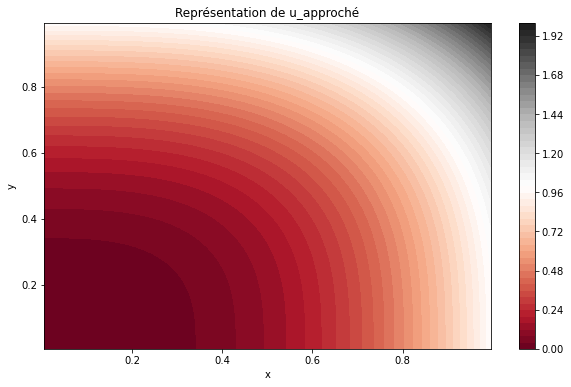

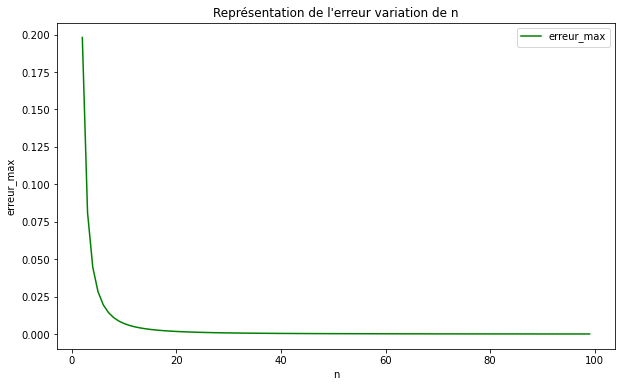

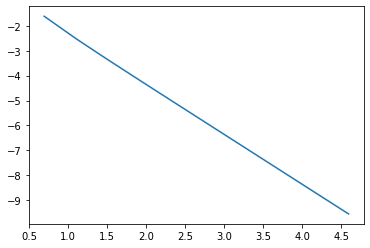

vitesse de convergence
-2.0077275157182792


In [13]:
def u(x, y):
    return x**3 + y**3

def f(x, y):
    return -6*x - 6*y

tracer(100, 100, f, u)

Erreur pour le maillage n, m
7.499589616100089e-05
Représentation de l'erreur en fonction du maillage


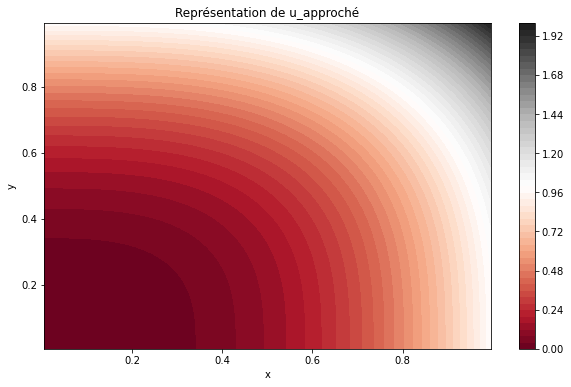

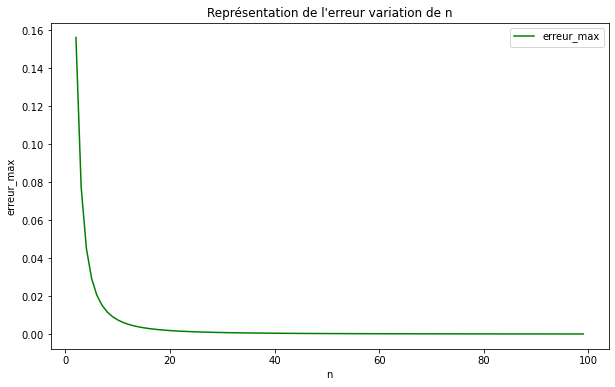

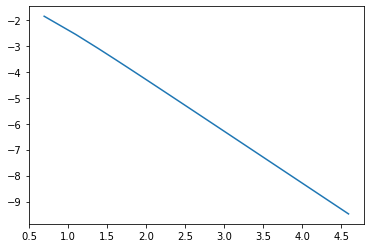

vitesse de convergence
-1.9862500381840476


In [8]:
def u(x, y):
    return x**3 + y**3

def f(x, y):
    return -6*x + -6*y

tracer(100, 100, f, u)